# alice-loves-bob

This notebook was presented at [QNLP 2019](http://www.cs.ox.ac.uk/QNLP2019/), a recording of the talk is available [here](https://www.youtube.com/watch?v=3UKqpL7Z0Uc).

In [1]:
from discopy import Ty, Word

s, n = Ty('s'), Ty('n')
Alice, loves, Bob = Word('Alice', n), Word('loves', n.r @ s @ n.l), Word('Bob', n)

print("Vocabulary:\n{}".format('\n'.join(map(repr, [Alice, loves, Bob]))))

Vocabulary:
Word('Alice', Ty('n'))
Word('loves', Ty(Ob('n', z=1), 's', Ob('n', z=-1)))
Word('Bob', Ty('n'))


Diagram for 'Alice loves Bob':


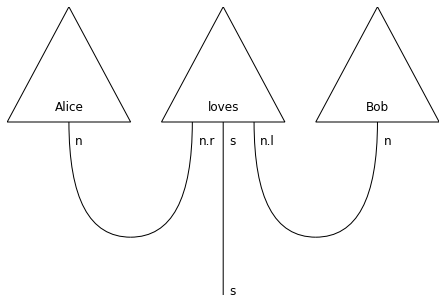

In [2]:
from discopy import Diagram, Id, Cup
from discopy.grammar import draw

grammar = Cup(n, n.r) @ Id(s) @ Cup(n.l, n)
parsing = {"{} {} {}.".format(subj, verb, obj): subj @ verb @ obj >> grammar
            for subj in [Alice, Bob] for verb in [loves] for obj in [Alice, Bob]}

diagram = parsing['Alice loves Bob.']
print("Diagram for 'Alice loves Bob':")
draw(diagram, draw_type_labels=True)

In [3]:
sentences = list(parsing.keys())
print("Grammatical sentences:\n{}".format('\n'.join(sentences)))

Grammatical sentences:
Alice loves Alice.
Alice loves Bob.
Bob loves Alice.
Bob loves Bob.


In [4]:
from discopy.quantum import Ket, H, Rx, CX, sqrt

def verb_ansatz(phase):
    return Ket(0, 0) >> H @ sqrt(2) @ Rx(phase) >> CX

print(verb_ansatz(0).eval())

Tensor(dom=Dim(1), cod=Dim(2, 2), array=[1.+0.j, 0.+0.j, 0.+0.j, 1.+0.j])


In [5]:
(verb_ansatz(0) >> verb_ansatz(0.5).dagger()).measure()

array([1.49975978e-32])

In [6]:
.25 * (verb_ansatz(0) >> verb_ansatz(0).dagger()).measure()

array([1.])

Circuit for 'Alice loves Bob':


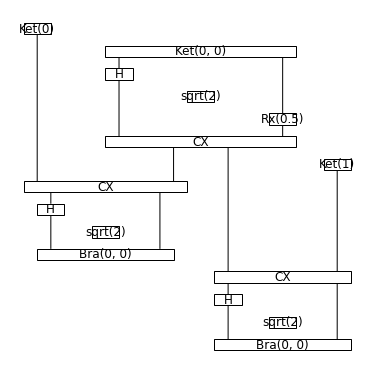

In [7]:
from discopy import CircuitFunctor, qubit

ob = {s: 0, n: 1}
ar = lambda params: {
    Alice: Ket(0), Bob: Ket(1),
    loves: verb_ansatz(params['loves'])}

F = lambda params: CircuitFunctor(ob, ar(params))

params0 = {'loves': 0.5}

print("Circuit for 'Alice loves Bob':")
F(params0)(parsing['Alice loves Bob.']).draw(
    aspect='auto', draw_type_labels=False, figsize=(5, 5))

In [8]:
print("Amplitude for 'Alice loves Bob':")
print(F(params0)(parsing['Alice loves Bob.']).eval())

Amplitude for 'Alice loves Bob':
Tensor(dom=Dim(1), cod=Dim(1), array=[0.-1.j])


In [9]:
evaluate = lambda F, sentence: F(parsing[sentence]).measure()

print("Does Alice love Bob?\n{}".format(
    "Yes" if evaluate(F(params0), 'Alice loves Bob.') else "No"))

Does Alice love Bob?
Yes


In [10]:
corpus = {sentence: evaluate(F(params0), sentence) for sentence in sentences}

epsilon = 1e-2

print("True sentences:\n{}\n".format('\n'.join(sentence
    for sentence, probability in corpus.items() if probability > 1 - epsilon)))
print("False sentences:\n{}".format('\n'.join(sentence
    for sentence, probability in corpus.items() if probability < epsilon)))

True sentences:
Alice loves Bob.
Bob loves Alice.

False sentences:
Alice loves Alice.
Bob loves Bob.


In [11]:
import jax.numpy as np
from jax import grad

def mean_squared(y_true, y_pred):
    return np.mean((np.array(y_true) - np.array(y_pred)) ** 2)

f = lambda phase: mean_squared(*zip(*[
    (evaluate(F(params0), sentence), evaluate(F({'loves': phase}), sentence))
     for sentence in sentences]))

grad(f)(0.75)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected.

The problem arose with the `float` function. If trying to convert the data type of a value, try using `x.astype(float)` or `jnp.array(x, float)` instead.



See https://jax.readthedocs.io/en/latest/faq.html#abstract-tracer-value-encountered-where-concrete-value-is-expected-error for more information.

Encountered tracer value: Traced<ConcreteArray(0.75, weak_type=True)>with<JVPTrace(level=2/0)>
  with primal = Traced<ConcreteArray(0.75, weak_type=True):JaxprTrace(level=1/0)>
       tangent = Traced<ShapedArray(float32[], weak_type=True):JaxprTrace(level=1/0)>

In [ ]:
from jax import vmap

x = np.arange(0.0, 1.0, 0.01)
y = vmap(f)(x)
dy = vmap(grad(f))(x)

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (12, 5)

plt.subplot(2, 1, 1)
plt.plot(x, y)
plt.title("functorial landscape for 'loves'")
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(x, dy)
plt.xlabel('phase')
plt.ylabel('grad')
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split

sentence_train, sentence_test = train_test_split(sentences, test_size=0.25, random_state=42)

print("Training set:\n{}\n".format('\n'.join(sentence_train)))
print("Testing set:\n{}".format('\n'.join(map(
    lambda x: 'Does ' + x.replace('loves', 'love').replace('.', '?'), sentence_test))))

In [ ]:
from jax import jit
from time import time

loss = {sentence: lambda params: mean_squared(corpus[sentence], evaluate(F(params), sentence))
                 for sentence in sentences}

@jit
def testing_loss(params):
    return np.mean(np.array([loss[sentence](params) for sentence in sentence_test]))

start = time()
print("{1:.3f} seconds to compile the testing loss of params0 ({0})".format(
    testing_loss(params0), time() - start))

step_size = 1e-2

@jit
def update(params):
    for sentence in sentence_train:
        params = {word: phase - step_size * grad(loss[sentence])(params)[word]
                  for word, phase in params.items()}
    return params

start = time()
print("{1:.3f} seconds to compile the update function just in time:\n{0}".format(
    update(params0), time() - start))

In [ ]:
from random import random, seed; seed(420)

print("Random parameter initialisation...")

params = {'loves': random()}
print("Initial parameters: {}".format(params))

print("Initial testing loss: {:.5f}\n".format(testing_loss(params)))

epochs, iterations = 7, 10

for epoch in range(epochs):
    start = time()
    for i in range(iterations):
        params = update(params)

    print("Epoch {} ({:.3f} milliseconds)".format(epoch, 1e3 * (time() - start)))
    print("Testing loss: {:.5f}".format(testing_loss(params)))
    print("params['loves'] = {:.3f}\n".format(params['loves']))

In [ ]:
print("Does Alice love Bob?")
print("Yes" if evaluate(F(params), 'Alice loves Bob.') > 1 - epsilon else "No")